In [4]:
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
from importlib import reload

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

from libs_unet.models import peakyfinder_0001
from libs_unet.training.spec_maker import spectrum_maker
#import libs_unet.models.spec_fitting
#reload(libs_unet.models.spec_fitting)
from libs_unet.models.spec_fitting import fit_spec

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [11]:
#reference data load
#elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)
#This dataset has spectra made single and pairs within first 77 elements
with open(datapath / 'training/el77_pairs.pickle', 'rb') as f:
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)
    el_symbol = pickle.load(f)

# set number of elements and wavelengths for this data
max_z = len(el_symbol)
#create dataset
#input needs a placeholder "channel" dimension since single channel
#learned labels already has max_z + 2 channels from spec_array
#data has to match weights which default to float() so cast data as same
rel_int_scale = 10**4
input_scale = 5
x_data = torch.tensor(x_data[:,None,:].astype('float32'))
y_data = torch.tensor(y_data.astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
y_data = input_scale * torch.log(rel_int_scale * y_data + 1)

#

In [9]:
#Load model and parameters for making predictions
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = peakyfinder_0001.LIBSUNet(max_z,len(wave))
param_path = top_dir / 'trained_models' / 'el77_pairs_0001'
model.load_state_dict(torch.load(param_path))


<All keys matched successfully>

sum x: 1.0
F: 0.500000
Tm: 0.500000


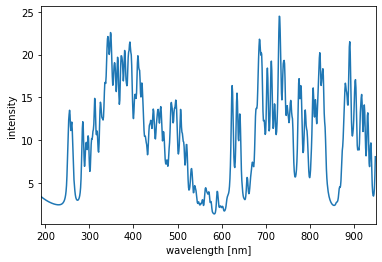

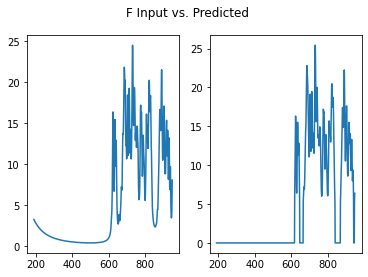

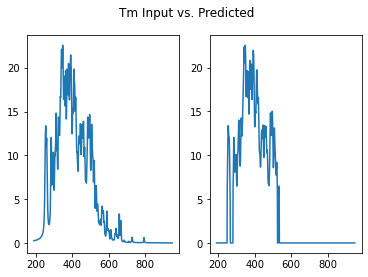

In [20]:
#look at the predicted vs. reference spectra
# sample and predicted data are all scaled and log transformed at this point
i_samp = 1977 #vary up to 8855
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #[22][760] # 20+2 (el + art + noi) spectra

#composite spectra and components
#x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
print(f"sum x: {torch.sum((torch.exp(x_sample[0][0]/input_scale) - 1)/rel_int_scale)}")
#show the element fractions
for i in range(max_z):
    frac = np.sum((np.exp(y_sample[i]/input_scale) - 1)/rel_int_scale)
    if frac > 0:
        print(f"{el_symbol[i]}: {frac:>4f}")
        
#first plot the transformed composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

#prediction (also transformed at this point)
plot_thresh = 5
model.eval()
with torch.no_grad():
    pred = model(x_sample)
    y_pred = pred[0].detach().numpy() #[77][760] corresponding predictions for y_sample
    y_pred[y_pred < plot_thresh] = 0
#element array indices where prediction above threshold
el_pred_idx = np.where(np.sum(y_pred[0:max_z], axis=1) > 0)[0]
#element array indices where input sample was positive
el_samp_idx = np.where(fracs[i_samp] > 0)[0]
#concatenate for indices where we'll plot
plot_ind = np.unique(np.concatenate((el_pred_idx, el_samp_idx), axis=None))
#https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
def pred_plot(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out
for plot_idx in plot_ind: #indices of elements
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'{el_symbol[plot_idx]} Input vs. Predicted ')
    pred_plot(ax1, wave, y_sample[plot_idx], {})
    pred_plot(ax2, wave, y_pred[plot_idx], {})

In [5]:
fracs.shape

(8855, 77)

In [21]:
#Visual inspection indicates that model is picking up the intended elements
#Let's find the threshold that maximizes % samples with correct elemental identification
#We're applying a peak height limit in log space here, so every 2.3 units ~order of mag
model.eval()
with torch.no_grad():
    pred = model(x_data).detach().numpy()

#Boolean array for presence of element for each of 590 samples 
fracs_bool = fracs > 0 #(8855, 77)
#Create the same dimension boolean for each prediction at a certain peak threshold (still log space)
#Log whether predicted elements match actual inputs so we can select best cutoff on % match
l_pred = len(pred)
hit_rate = np.zeros(len(range(40)))
cutoff = np.zeros(len(range(40)))
j= 0 #index for threshold accuracy array
for thresh in range(40):
    matches = 0 #track the correct element predictions at this threshold
    for i in range(l_pred):
        match = np.array_equal((np.max(pred[i,0:max_z,:], axis=1) > thresh), (fracs[i] > 0))
        matches += 1*match
    cutoff[j] = thresh
    hit_rate[j] = matches / l_pred
    j += 1

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

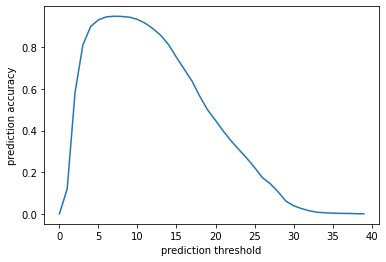

In [7]:
#review prediction accuracy by threshold
plt.plot(cutoff, hit_rate)
plt.xlabel('prediction threshold')
plt.ylabel('prediction accuracy')
plt.show

In [8]:
#which cutoff maximizes element ID accuracy
max_acc_ind = hit_rate.argmax()
print(f"max accuracy: { hit_rate[max_acc_ind]}")
print(f"at threshold: {cutoff[max_acc_ind]}")
#a cutoff of 10 maximizes prediction accuracy, refine within this range to one decimal point

max accuracy: 0.9491812535290797
at threshold: 7.0


In [11]:
hit_rate2 = np.zeros(len(np.arange(6,8,0.1)))
cutoff2 = np.zeros(len(np.arange(6,8,0.1)))
j= 0 #index for threshold accuracy array
for thresh in np.arange(6,8,0.1):
    matches = 0 #track the correct element predictions at this threshold
    for i in range(l_pred):
        match = np.array_equal((np.max(pred[i,0:max_z,:], axis=1) > thresh), (fracs[i] > 0))
        matches += 1*match
    cutoff2[j] = thresh
    hit_rate2[j] = matches / l_pred
    j += 1

<function matplotlib.pyplot.show(close=None, block=None)>

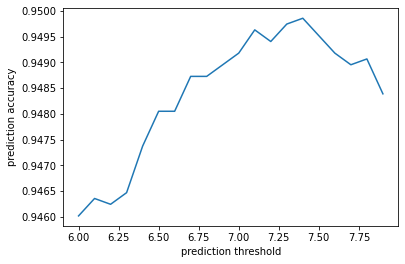

In [12]:
#review prediction accuracy by threshold
plt.plot(cutoff2, hit_rate2)
plt.xlabel('prediction threshold')
plt.ylabel('prediction accuracy')
plt.show

In [13]:
#which cutoff maximizes element ID accuracy
max_acc_ind = hit_rate2.argmax()
print(f"max accuracy: { hit_rate2[max_acc_ind]}")
print(f"at threshold: {cutoff2[max_acc_ind]}")
#no real improvement so we'll stick with 7 for simplicity

max accuracy: 0.9498588368153585
at threshold: 7.399999999999995


In [60]:
#characterize the nature of missed predictions in training/validation set
# for each element how often missed
# for each element how often incorrectly predicted
false_neg_dict = {}
false_pos_dict = {}

for el in el_symbol:
    false_neg_dict[el] = 0
    false_pos_dict[el] = 0

for i in range(l_pred):
    match = np.array_equal((np.max(pred[i,0:max_z,:], axis=1) > thresh), (fracs[i] > 0))
    if not match:
        sample_el = el_symbol[fracs[i] > 0]
        pred_el = el_symbol[np.max(pred[i,0:max_z,:], axis=1) > thresh]
        #log any missed elements
        for el in sample_el:
            if el not in pred_el:
                false_neg_dict[el] += 1
        #log any false predictions
        for el in pred_el:
            if el not in sample_el:
                false_pos_dict[el] += 1

<BarContainer object of 77 artists>

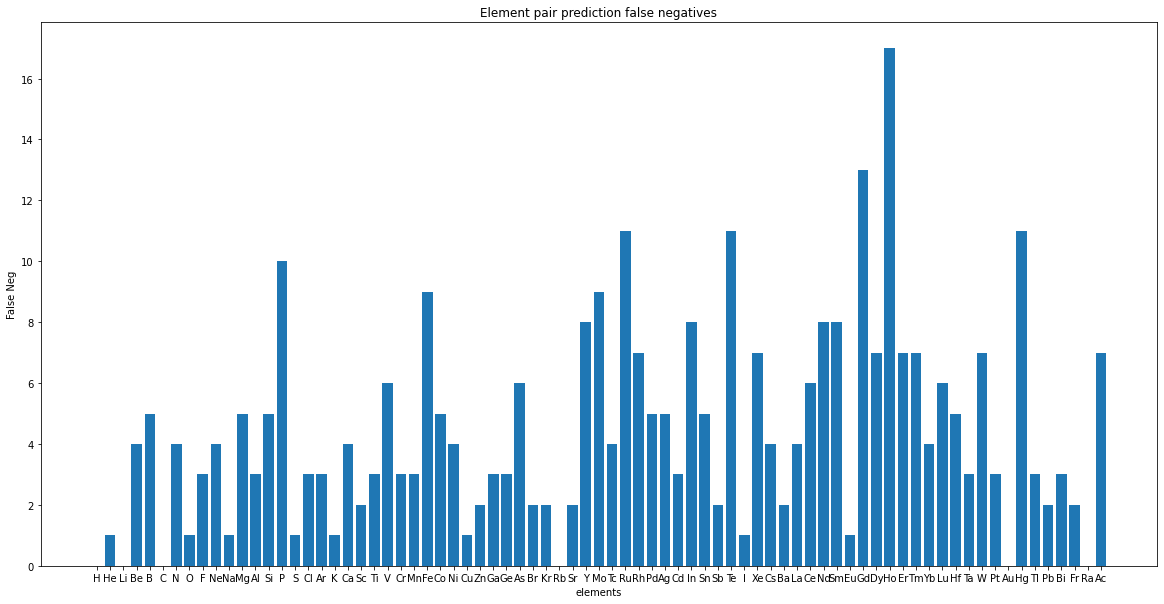

In [73]:
#Visualize false negatives
f_neg_x = np.array([])
f_neg_y = np.array([])
for x, y in false_neg_dict.items():
    f_neg_x = np.append(f_neg_x, x)
    f_neg_y = np.append(f_neg_y, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('False Neg')  # Add a y-label to the axes.
ax.set_title('Element pair prediction false negatives')  # Add a title to the axes.
ax.bar(f_neg_x, f_neg_y)

<BarContainer object of 77 artists>

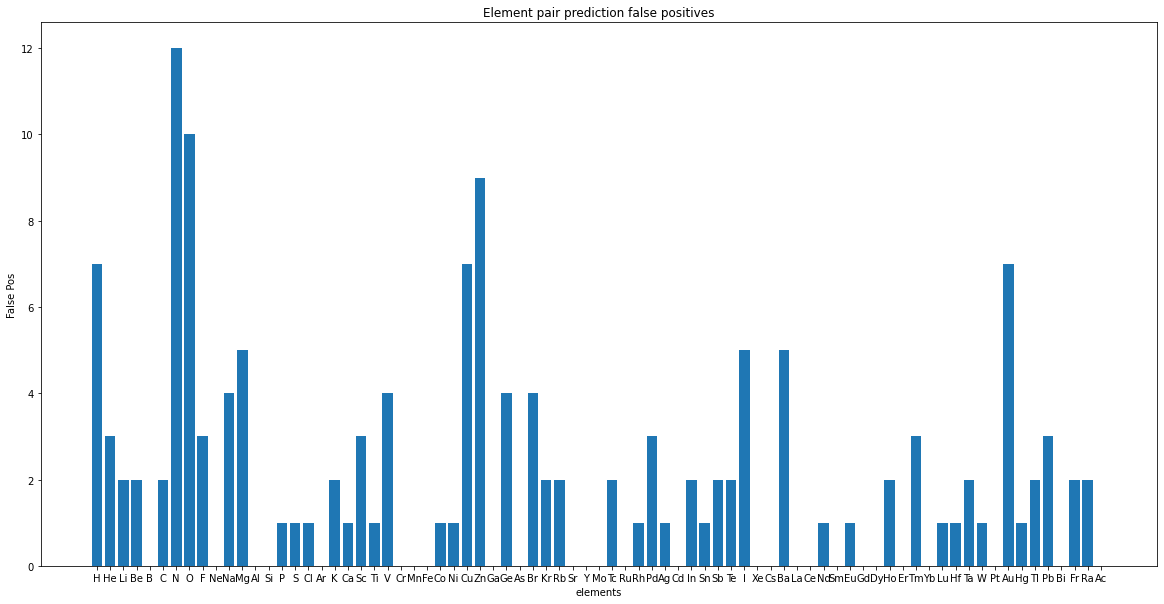

In [74]:
#Visualize false positives
f_pos_x = np.array([])
f_pos_y = np.array([])
for x, y in false_pos_dict.items():
    f_pos_x = np.append(f_pos_x, x)
    f_pos_y = np.append(f_pos_y, y)
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('elements')  # Add an x-label to the axes.
ax.set_ylabel('False Pos')  # Add a y-label to the axes.
ax.set_title('Element pair prediction false positives')  # Add a title to the axes.
ax.bar(f_pos_x, f_pos_y)

In [10]:
#check if this model can identify elements in Li2CO3
with open(datapath / 'training' / 'el77_meta.pickle', 'rb') as f:
    wave = pickle.load(f)
    el_symbol = pickle.load(f)
    el_index = pickle.load(f)

max_z = len(el_symbol)
spec_maker = spectrum_maker()
fracs_dict = {'Li':0.333, 'C':0.167, 'O':0.5}
wave, spec, spec_dict = spec_maker.make_spectra(fracs_dict)

x_custom = spec
y_custom = np.zeros((max_z + 2, 760))
for el in spec_dict:
    if el == 'art':
        y_custom[max_z] = spec_dict[el]
    elif el == 'noi':
        y_custom[max_z + 1] = spec_dict[el]
    else:
        y_custom[el_index[el]] = spec_dict[el]

In [11]:
type(x_custom) == np.ndarray

True

In [12]:
#scale and dimension data for model
rel_int_scale = 10**4
input_scale = 5
x_custom = torch.tensor(x_custom[None,None,:].astype('float32'))
y_custom = torch.tensor(y_custom[None,:,:].astype('float32'))
x_custom[x_custom < 0] = 0
y_custom[y_custom < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_custom = input_scale * torch.log(rel_int_scale * x_custom + 1)
y_custom = input_scale * torch.log(rel_int_scale * y_custom + 1)

model.eval()
with torch.no_grad():
    pred_c = model(x_custom).detach().numpy()

#see which elements are predicted
thresh = 7
pred_c_idx = np.max(pred_c[0,0:max_z,:], axis=1) > thresh
el_symbol[pred_c_idx] #array(['Li', 'C', 'O'], dtype='<U32'), success

array(['Li', 'C', 'O'], dtype='<U32')

In this next section we develop a recursive process that will:
1. Identify elements present with trained model (set evolves with recursion)
2. Determine relative weights of identified elements with L-S fit to input spectrum
3. Calculate residual spectrum and truncate negative intensities
4. If there is a material positive peak (> 0.5 threshold), rescale to 2x threshold
5. Begin process again with residual spectrum, note step 2 builds on prior elements

Note that we re-run L-S fit of atomic spectra to input spectrum with all elements identified. We want to have a conservative "stopping condition" such that we favor first elements selected by ML model. As such we should inspect the loss value as each element is added to ensure that (relative to identified weight) the reduction in loss is meaningful.

In [13]:
#generate reference spectra
spec_maker = spectrum_maker()

#create array of reference spectra for elements.
el_spec = np.zeros((max_z,760))
wave = range(190, 950)
for i in range(max_z):
    fracs_dict = {el_symbol[i]:1}
    wave, el_spec[i], spec_dict = spec_maker.make_spectra(fracs_dict)


sum for Li is 1.0


<function matplotlib.pyplot.show(close=None, block=None)>

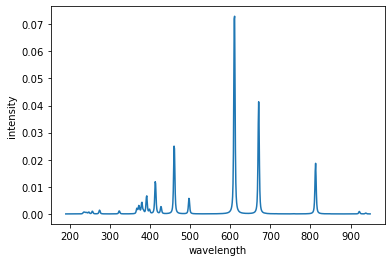

In [14]:
#check spectra
el_ind = 2
print(f"sum for {el_symbol[el_ind]} is {np.sum(el_spec[el_ind])}")
plt.plot(wave, el_spec[el_ind])
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show

In [15]:
#Generate predictions for train/valid data
#TODO look into wrapping x_data in data loader. This approach takes 7min and uses ~40Gb swap memory
model.eval()
with torch.no_grad():
    pred = model(x_data).detach().numpy()
#With a threshold established, identify the predicted elements for each sample
thresh = 7
#define a mask vector with 0,1 values to indicate identified elements in train/validation data
el_pred = 1*(np.max(pred[:,0:max_z,:], axis=2) > thresh)

NameError: name 'x_data' is not defined

In [23]:
#next task is to find the linear combination of the present spectra that minimizes error to input spectrum
#Try https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

sample_num = 400 #0-589 , use index for simplicity
input_log = x_data[sample_num].detach().numpy()
#Note we are fitting in non-transformed space
#x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
input_spec = (np.exp(input_log / input_scale) - 1) / rel_int_scale

#define the residuals function (x = weights, x_spec is dependent, ref_specs are independent)
def fun_fitspec(x, x_spec, ref_specs):
    return np.squeeze(np.sum((ref_specs.transpose() * x).transpose(), axis=0) - x_spec)
#initial weights as even allocation to identified elements
x0 = el_pred[sample_num] / np.sum(el_pred[sample_num]) #start with balanced allocation to candidates
#add bounds to zero out the non-identified elements
#bounds passed as a 2-tuple of vectors ([lower], [upper]) use np.inf for unbounded
#lower bound for all is non-negative weights
bnd_low = np.zeros(max_z)
#upper bound on candidates is 1, for which we can use el_pred mask
#need a small delta to avoid lb = ub
bnd_up = el_pred[sample_num] + 0.001
el_bounds = (bnd_low, bnd_up)
#now adjust upper bounds
el_fit = least_squares(fun_fitspec, x0, args=(input_spec, el_spec), bounds=el_bounds)




In [24]:
#review results
#library does not allow linear constraints so cannot constrain sum of x <=1
#prob ok as we can scale to 1?
fit_wts = el_fit.x.copy()
fit_wts[fit_wts < 0.01] = 0
fit_wts = fit_wts / np.sum(fit_wts)

for i in range(len(fit_wts)):
    if fracs[sample_num][i] > 0 or fit_wts[i] > 0:
        print(f"{el_symbol[i]}: ref: {fracs[sample_num][i]} pred: {np.round(fit_wts[i],3)}")

He: ref: 0.1 pred: 0.1
Br: ref: 0.9 pred: 0.9


<function matplotlib.pyplot.show(close=None, block=None)>

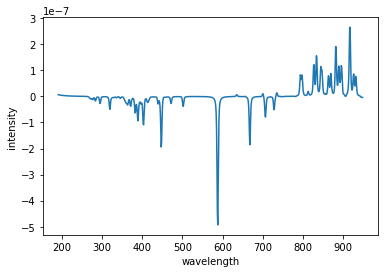

In [25]:
#now subtract this from input spectrum and determine if there is residual signal
#residual can be scaled up and fed into model once again!
resid_spec = np.squeeze(input_spec - np.sum((el_spec.transpose() * fit_wts).transpose(), axis=0))
#the fit will create negative values that we discard to focus on true signals
#resid_spec[resid_spec <0] = 0
plt.plot(wave, resid_spec)
plt.xlabel('wavelength')
plt.ylabel('intensity')
plt.show

In [28]:
print(f"fit SSE {np.sqrt(el_fit.cost)}")
print(f"max resid positive peak: {np.max(resid_spec)}")
print(f"min resid negative peak: {np.min(resid_spec)}")

fit SSE 6.154514016107029e-05
max resid positive peak: 2.6539566652314384e-07
min resid negative peak: -4.932200717688157e-07


In [26]:
#Test arbitrary mixture of elements Li2CO3
fracs_dict = {'Li':0.333, 'C':0.167, 'O':0.5}
#generate input spectrum
wave, test_spec, spec_dict = spec_maker.make_spectra(fracs_dict)
spec_input = np.stack((wave,test_spec), axis = -1)
fit_dict = fit_spec(spec_input)

In [34]:
report_el = np.array([])
for k in fracs_dict.keys():
    report_el = np.append(report_el, k)
for k in fit_dict.keys():
    if k not in report_el:
        report_el = np.append(report_el,k)

for el in report_el:
    input_wt = 0
    if el in fracs_dict:
        input_wt = fracs_dict[el]
    pred_wt = 0
    if el in fit_dict:
        pred_wt = np.round(fit_dict[el],3)
    print(f"{el}: ref: {input_wt} pred: {pred_wt}")


Li: ref: 0.333 pred: 0.333
C: ref: 0.167 pred: 0.167
O: ref: 0.5 pred: 0.5


In [62]:
#Test class wrapping the (to become) full iterative fitting process for experimental spectra
fit_dict = fit_spec(test_spec)
fit_dict #{'Li': 0.333, 'C': 0.167, 'O': 0.5}

{'Li': 0.333, 'C': 0.167, 'O': 0.5}

In [2]:
#Examine experimental spectrum for Li2CO3
libs_spec = np.genfromtxt(datapath / "experimental/LIBS_Li2CO3.csv", delimiter=',', skip_header=1)
fit_dict = fit_spec(libs_spec)
fit_dict

{'Li': 0.8556, 'N': 0.1444}